In [1]:
import networkx as nx
import random
import future
import numpy as np
from math import comb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import decimal
import hvplot.pandas
import panel as pn; pn.extension()
from panel.template import DarkTheme
decimal.getcontext().prec = 50  # 设置计算精度，防止计算溢出
class network_simulation:
    def __init__(self,order,rational_rate,imitation_rate,beta,
                 tax_coefficient,
                 subsidy_coefficient,iteration_times,initial_rate,k,n):
        self.G=nx.barabasi_albert_graph(200,n,seed=10)
        self.G.protection={node:[0.00] for node in self.G.nodes}
        self.n=n
        self.actual_iteration=0
        self.order=order
        self.k=k
        self.initial_rate=initial_rate
        self.iteration_times=iteration_times     
        self.rational_rate=rational_rate
        self.imitation_rate=imitation_rate
        self.beta=beta
        self.tax_coefficient=tax_coefficient
        self.subsidy_coefficient=subsidy_coefficient
        self.enterprise_nodes = np.array(list(self.G.nodes), ndmin=1) 
        self.enterprise_edges = np.array(self.G.edges, ndmin=2) 
        ###
        self.total_imitations = []
    def find_neighbor(self,agent, edges_list):
        agent_neighbor = []
        for a in range(len(edges_list)):
            if edges_list[a][0] == agent:
                agent_neighbor.append(edges_list[a][1])
            elif edges_list[a][1] == agent:
                agent_neighbor.append(edges_list[a][0])
            else:
                pass
        return agent_neighbor
    def complexes_protection(self,node):
        order=self.order
        T=self.actual_iteration
        neighbors=list(self.G.neighbors(node))
        protect_influence=[self.G.protection[i][T] for i in neighbors]
        total=len(neighbors)
        vertices=[i for i in range(1,order+1)]
        complexes=[]
        comp_co=[]
        comp_l=[]
        while len(neighbors)>0:
            if len(neighbors)>=order:
                num_vertice=random.choice(vertices)
            else:
                num_vertice=random.choice(range(1,len(neighbors)+1))
            nodes=random.sample(neighbors,k=num_vertice)
            neighbors=list(set(neighbors)-set(nodes))
            complexes.append(nodes)
            comp_l.append(len(nodes))#表示i单纯形的数量，下面“/”表示占所有单纯形的比例
        comp_co=[((1+comp_l.count(i)/len(comp_l))**(comb(i+1,3))) for i in comp_l] #表示i单纯形的强化作用
        for ind in range(len(complexes)):
            comp=complexes[ind]
            coefficient=comp_co[ind]
            complex_effectness=[]
            if coefficient>1:
                for node in comp:
                    complex_effectness.append(self.G.protection[node][-1])#complex_effectness 取决于单纯形中的节点的保护值，-1表示最新的保护值
                protect_influence.append(np.mean(complex_effectness)*coefficient)
        final_protection=sum(protect_influence)/total
        return final_protection
    def calculate_values(self, node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22):
        imitation = self.imitation_rate * self.complexes_protection(node_i)
        if len(self.total_imitations) < self.iteration_times:
            self.total_imitations.append(imitation)
        else:
            self.total_imitations[self.actual_iteration] += imitation
        pi_0_t = self.beta * (B * B11 + (1 - B) * B21) + (1 - self.beta) * (B * B12 + (1 - B) * B22)-imitation
        pi_1_t = self.beta * (A * A11 + (1 - A) * A21) + (1 - self.beta) * (A * A12 + (1 - A) * A22)+imitation
        
        return imitation, pi_0_t, pi_1_t
    
    def self_protection(self, node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22):
        _, pi_0_t, pi_1_t = self.calculate_values(node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22)
        def sigmoid(x, r):
            z = np.exp(-r * x)
            sig = (2 / (1 + z)) - 1
            return sig
        d = pi_1_t - pi_0_t
        return sigmoid(d, self.rational_rate)
    
    def green_payoff(self, node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22):
        _, _, pi_1_t = self.calculate_values(node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22)
        return pi_1_t
    def nongreen_payoff(self, node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22):
        _, pi_0_t, _ = self.calculate_values(node_i, A, A11, A12, A21, A22, B, B11, B12, B21, B22)
        return pi_0_t

    def run(self):
        enterprise_strategy_t0=[]
        self.cumulative_payoff = [[] for _ in range(len(self.enterprise_nodes))]  # 初始化累积收益
        for i in range(len(self.enterprise_nodes)):
            if np.random.rand(1)<=self.initial_rate:
                enterprise_strategy_t0.append((1,0))
            else:
                enterprise_strategy_t0.append((0,1))
        enterprise_strategy=enterprise_strategy_t0[:]
        t=[]
        t0=[]
        green_num_changelog=[0 for item in range(self.iteration_times)]
        for i in range(self.iteration_times):
            self.actual_iteration=i
            t.append(i)
            t0.append(i+1)
            green_num=0
            for e in range(len(self.enterprise_nodes)):
                if enterprise_strategy[e]==(1,0):
                    green_num=green_num+1
                else:
                    pass
            green_num_changelog[i]=green_num_changelog[i]+green_num
            payoff=[]
            for e in range(len(self.enterprise_nodes)):
                e_neighbor = self.find_neighbor(e+1,self.enterprise_edges)
                e_neighbor_num=len(e_neighbor)
                e_green_neighbor_num=0
                e_nongreen_neighbor_num=0
                e_payoff=0
                for l in range(len(e_neighbor)):
                    if enterprise_strategy[e_neighbor[l] - 1] == (1,0):
                        e_green_neighbor_num = e_green_neighbor_num + 1
                    else:
                        e_nongreen_neighbor_num = e_nongreen_neighbor_num + 1
                A=(e_green_neighbor_num+1)/(e_neighbor_num+1)
                B=(e_nongreen_neighbor_num+1)/(e_neighbor_num+1)
                A11=9-self.tax_coefficient*3+self.subsidy_coefficient*2-2
                A12=self.subsidy_coefficient*2-2-self.tax_coefficient*3
                A21=(9-self.tax_coefficient*3)+self.subsidy_coefficient*2-2
                A22=self.subsidy_coefficient*2-2-self.tax_coefficient*3
                B11=0-self.tax_coefficient*6
                B12=(6-self.tax_coefficient*6)
                B21=0-self.tax_coefficient*6
                B22=6-self.tax_coefficient*6
                protection=self.self_protection(e,A,A11,A12,A21,A22,B,B11,B12,B21,B22)
                self.G.protection[e].append(protection)
                if enterprise_strategy[e]==(1,0):
                    e_payoff=self.green_payoff(e,A,A11,A12,A21,A22,B,B11,B12,B21,B22)
                else:
                    e_payoff=self.nongreen_payoff(e,A,A11,A12,A21,A22,B,B11,B12,B21,B22)
                payoff.append(e_payoff)
                self.cumulative_payoff[e].append(e_payoff)  # 更新累积收益

            for j in range(len(self.enterprise_nodes)):
                # 计算节点j的邻居的策略参数
                j_neighbor = self.find_neighbor(j+1,self.enterprise_edges)
                j_neighbor_payoff=[]
                for a in range(len(j_neighbor)):
                    neighbor=j_neighbor[a]
                    neighbor_payoff=payoff[neighbor-1]
                    j_neighbor_payoff.append(neighbor_payoff)
                total_payoff=np.sum(payoff)
                j_neighbor_prob=[payoff_item/total_payoff for payoff_item in j_neighbor_payoff]
                choose_prob=0
                k1=0
                choose_neighbor=0
                l1=np.random.rand(1)
                while choose_prob<=l1:
                    if k1==len(j_neighbor_prob):
                        break
                    choose_neighbor=j_neighbor[k1]
                    choose_prob += j_neighbor_prob[k1]
                    k1+=1
                if enterprise_strategy[j]==enterprise_strategy[choose_neighbor-1]:
                    pass
                else:
                    ###
                    j_degree=len(j_neighbor)
                    choose_neighbor_degree=len(self.find_neighbor(choose_neighbor,self.enterprise_edges))
                    j_payoff=np.sum(self.cumulative_payoff[j])/j_degree  # 使用累积收益
                    choose_neighbor_payoff=np.sum(self.cumulative_payoff[choose_neighbor-1])/choose_neighbor_degree  # 使用累积收益
                    ecp=(j_payoff-choose_neighbor_payoff)/self.k
                    ecp=np.sum(ecp)
                    change_prob=1/(1+decimal.Decimal(math.e)**decimal.Decimal(ecp))
                    m=np.random.rand(1)
                    if m<=change_prob:
                        enterprise_strategy[j]=enterprise_strategy[choose_neighbor-1]
                    else:
                        pass   
        green_num_changelog=[item for item in green_num_changelog]
        self.green_num_changelog=green_num_changelog
        self.total_imitations = [total / 200 for total in self.total_imitations]

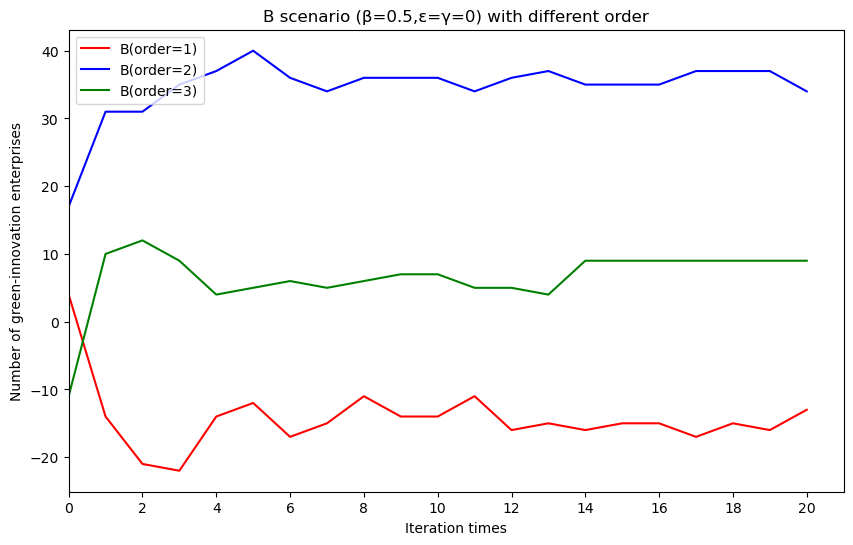

[  4. -14. -21. -22. -14. -12. -17. -15. -11. -14. -14. -11. -16. -15.
 -16. -15. -15. -17. -15. -16. -13.]
[17. 31. 31. 35. 37. 40. 36. 34. 36. 36. 36. 34. 36. 37. 35. 35. 35. 37.
 37. 37. 34.]
[-11.  10.  12.   9.   4.   5.   6.   5.   6.   7.   7.   5.   5.   4.
   9.   9.   9.   9.   9.   9.   9.]


In [16]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,k=k,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0,subsidy_coefficient=0)
simulation2 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0,subsidy_coefficient=0)
simulation3 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.4,
                                        tax_coefficient=0,subsidy_coefficient=0)
simulation4 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.4,
                                        tax_coefficient=0,subsidy_coefficient=0)
simulation5 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.3,
                                        tax_coefficient=0,subsidy_coefficient=0)
simulation6 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.3,
                                        tax_coefficient=0,subsidy_coefficient=0)
params = [
    [simulation1-simulation2,'B(order=1)','red','-'],
    [simulation3-simulation4,'B(order=2)','blue','-'],
    [simulation5-simulation6,'B(order=3)','green','-'],


]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('B scenario (β=0.5,ε=γ=0) with different order') 
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1-simulation2)
print(simulation3-simulation4)
print(simulation5-simulation6)

#plt.savefig("3.7_1.png",dpi=1200)

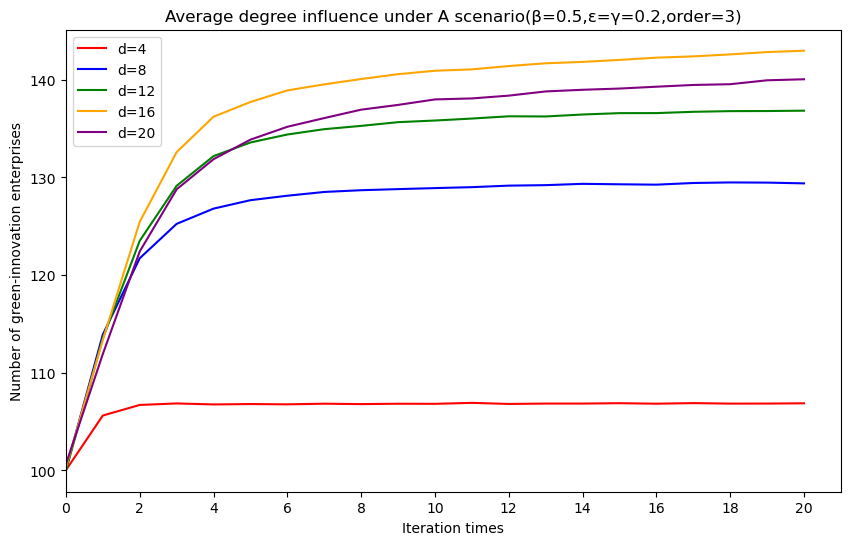

[100.028 105.622 106.706 106.86  106.758 106.798 106.768 106.834 106.792
 106.83  106.82  106.92  106.808 106.846 106.846 106.886 106.832 106.894
 106.842 106.846 106.876]
[100.118 113.91  121.722 125.244 126.804 127.668 128.126 128.51  128.69
 128.802 128.906 129.002 129.158 129.208 129.342 129.296 129.258 129.428
 129.486 129.468 129.39 ]
[ 99.972 113.514 123.512 129.14  132.178 133.576 134.392 134.938 135.276
 135.656 135.824 136.026 136.256 136.24  136.44  136.58  136.584 136.716
 136.786 136.796 136.832]
[100.304 113.358 125.448 132.586 136.214 137.72  138.906 139.526 140.074
 140.568 140.92  141.062 141.402 141.684 141.826 142.028 142.26  142.39
 142.594 142.832 142.97 ]
[100.634 111.916 122.418 128.778 131.864 133.866 135.182 136.074 136.936
 137.422 137.984 138.086 138.372 138.802 138.972 139.096 139.286 139.464
 139.542 139.942 140.048]


In [5]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,k=k,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(500,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=2,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation2 = run_simulation(500,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=4,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation3 = run_simulation(500,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation4 = run_simulation(500,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=8,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation6 = run_simulation(500,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=10,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
params = [
    [simulation1,'d=4','red','-'],
    [simulation2,'d=8','blue','-'],
    [simulation3,'d=12','green','-'],
    [simulation4,'d=16','orange','-'],
    [simulation6,'d=20','purple','-'],
]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('Average degree influence under A scenario(β=0.5,ε=γ=0.2,order=3)') 
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)
print(simulation4)
print(simulation6)
#plt.savefig("3.7_1.png",dpi=1200)

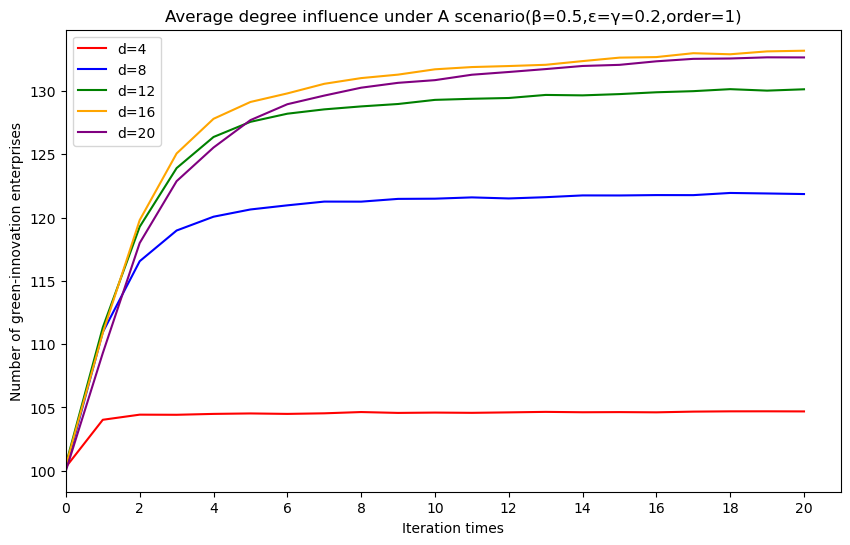

[100.292 104.026 104.43  104.42  104.49  104.526 104.49  104.536 104.636
 104.568 104.594 104.574 104.61  104.65  104.62  104.632 104.614 104.67
 104.692 104.694 104.686]
[100.156 110.948 116.55  118.974 120.064 120.636 120.962 121.258 121.254
 121.472 121.488 121.59  121.506 121.606 121.746 121.742 121.772 121.768
 121.94  121.9   121.854]
[100.51  111.318 119.272 123.904 126.36  127.558 128.2   128.542 128.776
 128.966 129.292 129.378 129.44  129.682 129.648 129.748 129.892 129.98
 130.138 130.022 130.128]
[100.406 110.894 119.798 125.058 127.796 129.126 129.802 130.56  131.012
 131.286 131.706 131.884 131.964 132.062 132.354 132.628 132.672 132.978
 132.894 133.122 133.174]
[100.002 109.294 117.99  122.872 125.528 127.692 128.948 129.63  130.254
 130.638 130.85  131.278 131.494 131.724 131.97  132.058 132.338 132.532
 132.56  132.652 132.644]


In [4]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,k=k,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(500,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=2,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation2 = run_simulation(500,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=4,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation3 = run_simulation(500,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation4 = run_simulation(500,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=8,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation6 = run_simulation(500,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=10,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
params = [
    [simulation1,'d=4','red','-'],
    [simulation2,'d=8','blue','-'],
    [simulation3,'d=12','green','-'],
    [simulation4,'d=16','orange','-'],
    [simulation6,'d=20','purple','-'],
]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('Average degree influence under A scenario(β=0.5,ε=γ=0.2,order=1)') 
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)
print(simulation4)
print(simulation6)
#plt.savefig("3.7_1.png",dpi=1200)

Result of run 1:[0.0, -8.226330537903489e-16, -1.6125048999384795e-15, -2.3962138776017737e-15, -3.209358199810114e-15, -4.0012888415945066e-15, -4.16892999909189e-15, -4.729393060468258e-15, -4.810992983136128e-15, -4.835336666830237e-15, -4.92628088409731e-15, -5.26141768108643e-15, -5.594210744532362e-15, -5.600533020528821e-15, -5.605887066759897e-15, -5.60320578827537e-15, -5.5963181714052316e-15, -5.60320578827537e-15, -5.600533020528821e-15, -5.598466854477658e-15, -5.614443913357633e-15]
Result of run 1:[-2.449419213672642e-16, -1.7178544264266866e-15, -3.912224750339135e-15, -6.956128274571536e-15, -1.1247092850521931e-14, -1.7378748317999463e-14, -2.6675641347920727e-14, -3.8964485759653885e-14, -5.72232694284235e-14, -8.348020594020528e-14, -1.1785222495964328e-13, -1.680483999636066e-13, -2.389963802350163e-13, -3.4269344308179336e-13, -4.948680427892088e-13, -7.079078696802877e-13, -1.0223805403768593e-12, -1.4535594658798745e-12, -2.089334904474721e-12, -2.984649903577189

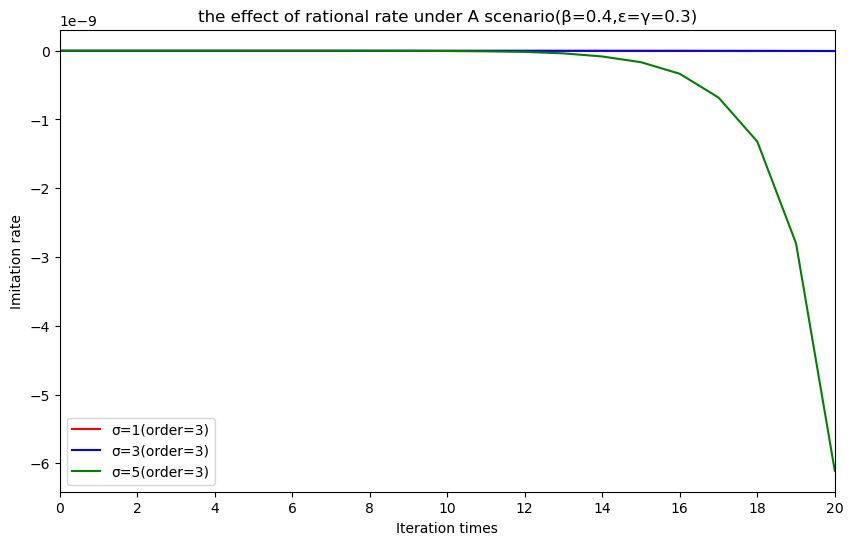

In [14]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,k=k,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()

        results.append(simulation.total_imitations)
        if h<2:
            print(f"Result of run {h+1}:{simulation.total_imitations}")
        elif h==2:
            print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.1,subsidy_coefficient=0.1)
simulation2 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=2,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.1,subsidy_coefficient=0.1)
simulation3 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.1,subsidy_coefficient=0.1)

params = [
    [simulation1,'σ=1(order=3)','red','-'],
    [simulation2,'σ=3(order=3)','blue','-'],
    [simulation3,'σ=5(order=3)','green','-'],

]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Imitation rate')
    ax.set_title('the effect of rational rate under A scenario(β=0.4,ε=γ=0.3)')
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 20)
    plt.show()
plot(params)
#plt.savefig("3.7_1.png",dpi=1200)

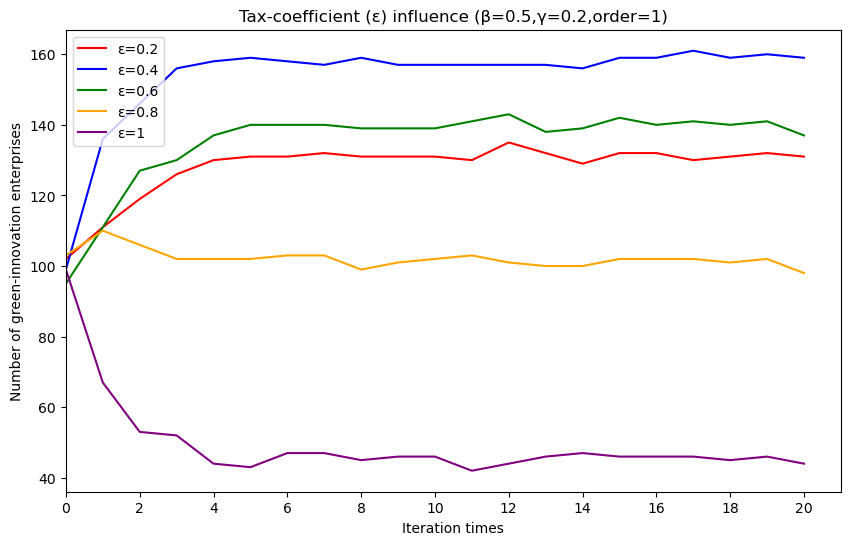

[102. 111. 119. 126. 130. 131. 131. 132. 131. 131. 131. 130. 135. 132.
 129. 132. 132. 130. 131. 132. 131.]
[ 99. 136. 146. 156. 158. 159. 158. 157. 159. 157. 157. 157. 157. 157.
 156. 159. 159. 161. 159. 160. 159.]
[ 95. 111. 127. 130. 137. 140. 140. 140. 139. 139. 139. 141. 143. 138.
 139. 142. 140. 141. 140. 141. 137.]
[103. 110. 106. 102. 102. 102. 103. 103.  99. 101. 102. 103. 101. 100.
 100. 102. 102. 102. 101. 102.  98.]
[99. 67. 53. 52. 44. 43. 47. 47. 45. 46. 46. 42. 44. 46. 47. 46. 46. 46.
 45. 46. 44.]


In [13]:
def run_simulation(run_times:int,rational_rate=9,iteration_times=5,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.4,
                                        tax_coefficient=0.2,subsidy_coefficient=0.1):
    results=[]
    for h in range(run_times):
        simulation=network_simulation(rational_rate=rational_rate,iteration_times=iteration_times,initial_rate=initial_rate,
                                        order=order,imitation_rate=imitation_rate,n=n,beta=beta,k=k,
                                        tax_coefficient=tax_coefficient,subsidy_coefficient=subsidy_coefficient)
        simulation.run()
        results.append(simulation.green_num_changelog)
        #if h<2:
        #    print(f"Result of run {h+1}:{simulation.green_num_changelog}")
        #elif h==2:
        #    print("...")
    return np.mean(results,axis=0)

simulation1 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation2 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=2,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation3 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=3,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0.2,subsidy_coefficient=0.2)
simulation4 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=1,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0,subsidy_coefficient=0)
simulation5 = run_simulation(1,rational_rate=9,iteration_times=21,initial_rate=0.5,k=0.1,
                                        order=2,imitation_rate=0.1,n=6,beta=0.5,
                                        tax_coefficient=0,subsidy_coefficient=0)

params = [
    [simulation1,'ε=0.2','red','-'],
    [simulation2,'ε=0.4','blue','-'],
    [simulation3,'ε=0.6','green','-'],
    [simulation4,'ε=0.8','orange','-'],
    [simulation5,'ε=1','purple','-'],


]
def plot(params):
    fig, ax = plt.subplots(figsize=(10, 6))
    for param in params:
        ax.plot(param[0], label=param[1],color=param[2],linestyle=param[3])
    ax.set_xlabel('Iteration times')
    ax.set_ylabel('Number of green-innovation enterprises')
    ax.set_title('Tax-coefficient (ε) influence (β=0.5,γ=0.2,order=1)')
    ax.legend()
    plt.xticks(np.arange(0, 21, 2))
    plt.xlim(0, 21)
    plt.show()
plot(params)
print(simulation1)
print(simulation2)
print(simulation3)
print(simulation4)
print(simulation5)
#plt.savefig("3.7_1.png",dpi=1200)